In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_error
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,17.0,1530.0,2335,Liberty,Big South,fcs,10.0,1467.0
1,332412579,2013,1,regular,True,False,3994.0,2579,South Carolina,SEC,fbs,27.0,1759.0,153,North Carolina,ACC,fbs,10.0,1638.0
2,332410154,2013,1,regular,True,False,3630.0,154,Wake Forest,ACC,fbs,31.0,NaN,2506,Presbyterian,Big South,fcs,7.0,NaN
3,332412623,2013,1,regular,True,False,3878.0,2623,Missouri State,MVFC,fcs,17.0,NaN,2466,Northwestern State,Southland,fcs,23.0,NaN
4,332412230,2013,1,regular,True,True,3681.0,2230,Fordham,Patriot,fcs,51.0,NaN,227,Rhode Island,CAA,fcs,26.0,NaN


In [5]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [6]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    df_venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    df_venues = pd.DataFrame([val.to_dict() for val in data])
    df_venues.columns = convert_to_snake_case(df_venues.columns)
    df_venues.to_parquet(file_path)

df_venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [7]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2013.parquet from cached data
Reading ../data/drives/2014.parquet from cached data
Reading ../data/drives/2015.parquet from cached data
Reading ../data/drives/2016.parquet from cached data
Reading ../data/drives/2017.parquet from cached data
Reading ../data/drives/2018.parquet from cached data
Reading ../data/drives/2019.parquet from cached data
Reading ../data/drives/2020.parquet from cached data
Reading ../data/drives/2021.parquet from cached data
Reading ../data/drives/2022.parquet from cached data
Reading ../data/drives/2023.parquet from cached data
Reading ../data/drives/2024.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000601,1,False,1,25,75,1,36,64,6,11,PUNT,True,0,0,0,0,15,0,11,55
1,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000602,2,True,1,77,77,1,16,16,12,61,FG GOOD,False,0,0,3,0,11,55,5,52
2,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000603,3,False,1,48,52,1,76,24,9,28,FG MISSED,True,0,3,0,3,5,52,2,21
3,Southern Utah,Big Sky,South Alabama,Sun Belt,332410006,33241000604,4,True,1,76,76,1,0,0,3,76,RUSHING TD,False,3,0,10,0,2,21,1,16
4,South Alabama,Sun Belt,Southern Utah,Big Sky,332410006,33241000605,5,False,1,25,75,2,45,55,5,20,PUNT,True,0,10,0,10,1,16,14,53


In [8]:
punt_events = [c for c in df_drives.drive_result.unique() if 'PUNT' in c]
print(punt_events)
df_drives = df_drives[df_drives.drive_result.isin(punt_events)].reset_index(drop=True)
df_drives.shape

['PUNT', 'PUNT RETURN TD', 'PUNT TD', 'BLOCKED PUNT']


(112864, 26)

In [9]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


## 2. Join and Filter the Data

In [10]:
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
    'away_id', 'away_team','away_conference', 'away_division']
drive_cols = ['offense', 'defense',
       'game_id', 'id', 'drive_number', 'start_yards_to_goal',
       'end_yards_to_goal', 'drive_result',
       'end_offense_score', 'end_defense_score',
       'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds']
weather_cols = ['id', 'game_indoors', 'temperature', 'dew_point', 'humidity',
       'precipitation', 'snowfall', 'wind_speed', 'pressure', 'weather_condition']
venue_cols = ['id', 'elevation', 'grass']
elo_cols = ['season', 'week', 'team_id', 'elo']

df = (
    df_games[game_cols].rename(columns={'id': 'game_id'})
    .merge(
        (
            df_drives
            [drive_cols]
            .rename(columns={'id': 'drive_id'})
        ),
        on=['game_id'],
        how='left',
    )
    .dropna(subset=['drive_id'])
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
    .merge(
        df_venues[venue_cols].rename(columns={'id': 'venue_id'}),
        on=['venue_id'],
        how='left',
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
)

df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230906,6.0,80.0,83.0,PUNT,0.0,7.0,7.0,0.0,2.0,12.0,19.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.3641663,False,1954.443118,1553.191164


In [11]:
df.drive_result.value_counts()

drive_result
PUNT              111942
PUNT RETURN TD       483
PUNT TD              429
BLOCKED PUNT          10
Name: count, dtype: int64

## 3. Feature Engineering

In [12]:
df = df.assign(
    end_drive_pct_game_played = (((df['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df['end_time_minutes'] * 60 + df['end_time_seconds']))) / (4 * 15 * 60),
    start_drive_pct_game_played = (((df['start_period'] - 1) * 15 * 60) + ((15 * 60) - (df['start_time_minutes'] * 60 + df['start_time_seconds']))) / (4 * 15 * 60),
    score_diff = df['start_offense_score'] - df['start_defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home_team], [0, 1], default=-1),
    offense_division = np.where(df['offense'] == df['home_team'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home_team'], df['away_division'], df['home_division']),
    grass = df.grass.fillna(False),
    game_indoors = df.game_indoors.fillna(False),
    temperature = df.temperature.fillna(int(df.temperature.mean())),
    wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
    elevation = df.elevation.fillna(int(df.elevation.astype(float).mean())),
    precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean()))),
    punting_team_pregame_elo = np.where(df.home_team == df.offense, df.home_pregame_elo, df.away_pregame_elo),
    receiving_team_pregame_elo = np.where(df.home_team == df.offense, df.away_pregame_elo, df.home_pregame_elo),
    receiving_team_points_scored = df.end_defense_score - df.start_defense_score,
    punting_team_points_scored = df.end_offense_score - df.start_offense_score,
)

df['elevation'] = df['elevation'].astype(float)    

df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38220/3324540753.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = df.grass.fillna(False),
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38220/3324540753.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,end_drive_pct_game_played,start_drive_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.169444,0.135833,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.199167,0.169444,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.215000,0.199167,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,0.215000,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230906,6.0,80.0,83.0,PUNT,0.0,7.0,7.0,0.0,2.0,12.0,19.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,0.294722,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0


In [13]:
df.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,end_drive_pct_game_played,start_drive_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.169444,0.135833,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.199167,0.169444,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.215000,0.199167,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,0.215000,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230906,6.0,80.0,83.0,PUNT,0.0,7.0,7.0,0.0,2.0,12.0,19.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,0.294722,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0


In [14]:
feasible_receiving_team_points_scored = [0, 6, 7, 8] # Disregarding the possibility of a safetys against punting team
feasible_punting_team_points_scored = [0, 2] # Disregarding the possibility of touchdowns scored by the punting team

df_punts = (
    df
    .rename(columns={
        'end_yards_to_goal':'punt_team_end_yards_to_goal',
        'end_drive_pct_game_played':'punt_team_end_pct_game_played',
    })
    .merge(
        (
            df[['game_id','drive_number','start_drive_pct_game_played','start_yards_to_goal']]
            .rename(columns={
                'start_yards_to_goal':'receiving_team_start_yards_to_goal',
                'start_drive_pct_game_played':'receiving_team_start_pct_game_played'
            })
            .assign(drive_number=lambda x: x['drive_number'] - 1)
        ),
        on=['game_id','drive_number'],
        how='left'
    )
    .dropna(subset=['receiving_team_start_yards_to_goal'])
    .query('receiving_team_points_scored in @feasible_receiving_team_points_scored and '
           'punting_team_points_scored in @feasible_punting_team_points_scored')
    .query('receiving_team_start_pct_game_played != 0.5')
    .drop(columns=['start_drive_pct_game_played'])
)

conditions = [
    df_punts.receiving_team_points_scored.isin([6,7,8]),
    df_punts.punting_team_points_scored == 2,
]
choices = [
    0,
    100
]
df_punts['receiving_team_start_yards_to_goal'] = np.select(conditions, choices, default=df_punts['receiving_team_start_yards_to_goal'])

In [15]:
df_punts.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,punt_team_end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,punt_team_end_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,receiving_team_start_pct_game_played,receiving_team_start_yards_to_goal
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.169444,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.169444,58.0
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.199167,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0,0.199167,80.0
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.215000,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.215000,55.0
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0,0.294722,80.0
6,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230911,11.0,75.0,59.0,PUNT,3.0,7.0,7.0,3.0,3.0,15.0,0.0,3.0,12.0,34.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.540556,-4.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.540556,85.0


In [16]:
# Filter out overtime plays
df_punts = df_punts.query('0 < end_period <= 4')

# Game must be completed
df_punts = df_punts.query('completed == True')

df_punts = df_punts.query('0 <= receiving_team_start_pct_game_played <= 1')
df_punts = df_punts.query('0 <= punt_team_end_pct_game_played <= 1')

df_punts.reset_index(drop=True, inplace=True)

## 4. Feature Data Viz

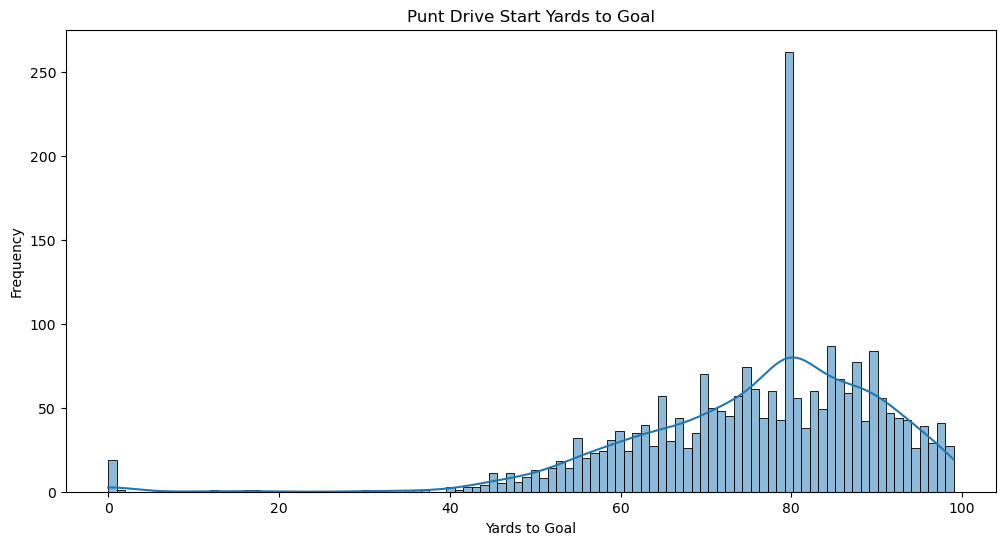

In [17]:
# plot a histogram of punt drive start yards to goal
plt.figure(figsize=(12,6))
sns.histplot(df_punts.query('season == 2024 and home_division == "fbs" and away_division == "fbs"').receiving_team_start_yards_to_goal, bins=100, kde=True)
plt.title("Punt Drive Start Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38220/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


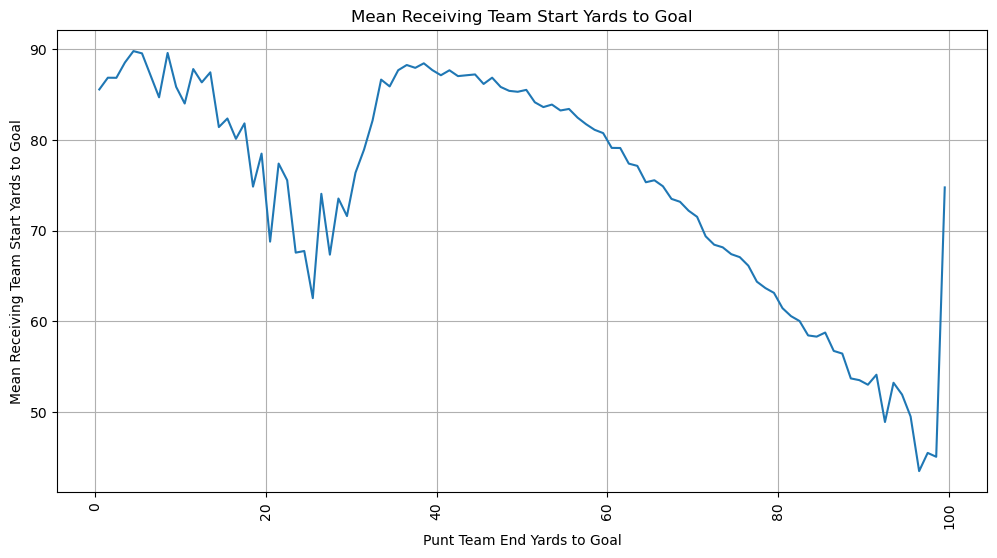

In [18]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [19]:
df_punts_inside_40 = df_punts.query('punt_team_end_yards_to_goal < 40').reset_index(drop=True)
df_punts = df_punts.query('punt_team_end_yards_to_goal >= 40').reset_index(drop=True)

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38220/913131268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


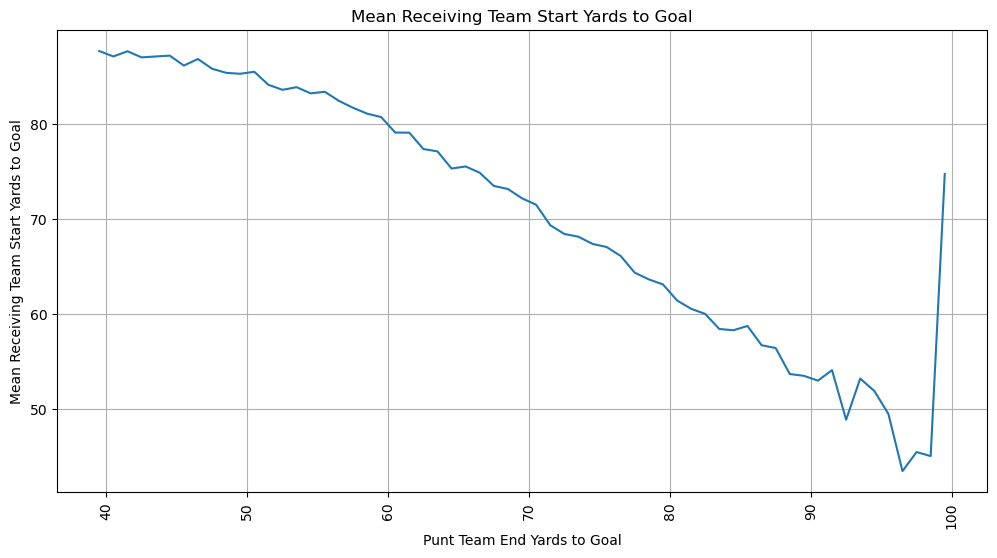

In [20]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean'))
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan  # Use the midpoint of the bin
)

# Plot the mean receiving team start yards to goal
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal
)
plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Mean Receiving Team Start Yards to Goal")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [21]:
df_punts.head()

,game_id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,defense,drive_id,drive_number,start_yards_to_goal,punt_team_end_yards_to_goal,drive_result,end_offense_score,end_defense_score,start_defense_score,start_offense_score,start_period,start_time_minutes,start_time_seconds,end_period,end_time_minutes,end_time_seconds,game_indoors,temperature,dew_point,humidity,precipitation,snowfall,wind_speed,pressure,weather_condition,elevation,grass,home_pregame_elo,away_pregame_elo,punt_team_end_pct_game_played,score_diff,is_home_team,offense_division,defense_division,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_points_scored,punting_team_points_scored,receiving_team_start_pct_game_played,receiving_team_start_yards_to_goal
0,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230902,2.0,82.0,78.0,PUNT,0.0,7.0,7.0,0.0,1.0,6.0,51.0,1.0,4.0,50.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.169444,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.169444,58.0
1,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230903,3.0,58.0,55.0,PUNT,7.0,0.0,0.0,7.0,1.0,4.0,50.0,1.0,3.0,3.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.199167,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0,0.199167,80.0
2,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230904,4.0,80.0,86.0,PUNT,0.0,7.0,7.0,0.0,1.0,3.0,3.0,1.0,2.0,6.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.215000,-7.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.215000,55.0
3,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Kent State,Liberty,33241230905,5.0,55.0,44.0,PUNT,7.0,0.0,0.0,7.0,1.0,2.0,6.0,2.0,12.0,19.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.294722,7.0,1,fbs,fcs,1954.443118,1553.191164,0.0,0.0,0.294722,80.0
4,332412309,2013,1,regular,True,False,3696.0,2309,Kent State,Mid-American,fbs,2335,Liberty,Big South,fcs,Liberty,Kent State,33241230911,11.0,75.0,59.0,PUNT,3.0,7.0,7.0,3.0,3.0,15.0,0.0,3.0,12.0,34.0,False,82.0,63.7,54.0,0.0,0.0,3.4,1016.5,None,321.364166,False,1954.443118,1553.191164,0.540556,-4.0,-1,fcs,fbs,1553.191164,1954.443118,0.0,0.0,0.540556,85.0


In [22]:
df_punts.columns

Index(['game_id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
       'venue_id', 'home_id', 'home_team', 'home_conference', 'home_division',
       'away_id', 'away_team', 'away_conference', 'away_division', 'offense',
       'defense', 'drive_id', 'drive_number', 'start_yards_to_goal',
       'punt_team_end_yards_to_goal', 'drive_result', 'end_offense_score',
       'end_defense_score', 'start_defense_score', 'start_offense_score',
       'start_period', 'start_time_minutes', 'start_time_seconds',
       'end_period', 'end_time_minutes', 'end_time_seconds', 'game_indoors',
       'temperature', 'dew_point', 'humidity', 'precipitation', 'snowfall',
       'wind_speed', 'pressure', 'weather_condition', 'elevation', 'grass',
       'home_pregame_elo', 'away_pregame_elo', 'punt_team_end_pct_game_played',
       'score_diff', 'is_home_team', 'offense_division', 'defense_division',
       'punting_team_pregame_elo', 'receiving_team_pregame_elo',
       'receiving_team_poin

## 5. Modeling

In [23]:
data = (
    df_punts[['game_id',
       'punt_team_end_yards_to_goal', 'is_home_team', 
       'grass', 'elevation', 'wind_speed', 'precipitation', 'temperature', 'game_indoors',
       'punt_team_end_pct_game_played', 'score_diff',
       'punting_team_pregame_elo', 'receiving_team_pregame_elo',
       'receiving_team_start_yards_to_goal']]
    .rename(columns={
        'punt_team_end_pct_game_played': 'pct_game_played',
    })
)

# Split into 80-20 train val set by game_id
game_ids = df_punts.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)]

In [24]:
data.head()

,game_id,punt_team_end_yards_to_goal,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,pct_game_played,score_diff,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_start_yards_to_goal
0,332412309,78.0,-1,False,321.364166,3.4,0.0,82.0,False,0.169444,-7.0,1553.191164,1954.443118,58.0
1,332412309,55.0,1,False,321.364166,3.4,0.0,82.0,False,0.199167,7.0,1954.443118,1553.191164,80.0
2,332412309,86.0,-1,False,321.364166,3.4,0.0,82.0,False,0.215000,-7.0,1553.191164,1954.443118,55.0
3,332412309,44.0,1,False,321.364166,3.4,0.0,82.0,False,0.294722,7.0,1954.443118,1553.191164,80.0
4,332412309,59.0,-1,False,321.364166,3.4,0.0,82.0,False,0.540556,-4.0,1553.191164,1954.443118,85.0


In [25]:
data.isna().sum()

game_id                               0
punt_team_end_yards_to_goal           0
is_home_team                          0
grass                                 0
elevation                             0
wind_speed                            0
precipitation                         0
temperature                           0
game_indoors                          0
pct_game_played                       0
score_diff                            0
punting_team_pregame_elo              0
receiving_team_pregame_elo            0
receiving_team_start_yards_to_goal    0
dtype: int64

In [26]:
model_dir = os.path.join(DATA_DIR, 'models', 'punt_yards_to_goal')

model_files = [f for f in os.listdir(model_dir) if f.endswith('.json')]

models = []
for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = xgb.Booster()  # Create an empty Booster object
    model.load_model(model_path)  # Load the model from the json file
    models.append(model)

print(f"Loaded {len(models)} models from the '{model_dir}' folder.")

Loaded 10 models from the '../data/models/punt_yards_to_goal' folder.


In [32]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

N_BOOTSTRAP = 100
N_SAMPLE = 20000
    
feature_names = data_train.drop(columns=['game_id', 'receiving_team_start_yards_to_goal']).columns.tolist()
monotonic_constraints_map = {
    "punt_team_end_yards_to_goal": -1,
    "wind_speed": -1,
    "elevation": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "game_indoors": 1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

interaction_constraints = [
    ["punting_team_pregame_elo", "receiving_team_pregame_elo", "score_diff", "pct_game_played"],
]

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "reg:absoluteerror",
        "monotone_constraints": monotonic_constraints,
        "interaction_constraints": interaction_constraints,
        "eval_metric": "mae",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
  
    return mean_absolute_error(dvalid.get_label(), preds)

# Bootstrapping
models = []
for i in tqdm(range(N_BOOTSTRAP), desc='Bootstrapping'):
    # Bootstrap sampling (row-level)
    train_data = data_train.sample(n=N_SAMPLE, replace=True, random_state=SEED)

    # Row-wise 80-20 split
    train, valid = train_test_split(train_data, test_size=0.2, random_state=SEED)

    train_x = train.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
    train_y = train['receiving_team_start_yards_to_goal']
    valid_x = valid.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
    valid_y = valid['receiving_team_start_yards_to_goal']

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(
        study_name="punt_yards_to_goal",
        direction="minimize", 
        load_if_exists=True
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=50)

    # Train a model with the best params
    best_params = {
        **study.best_trial.params,
        'interaction_constraints': interaction_constraints,
        'nthread': -1,
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'monotone_constraints': monotonic_constraints,
        'eval_metric': 'mae',
        'seed': SEED,
    }
    bst = xgb.train(
        best_params, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    models.append(bst)

Bootstrapping: 100%|██████████| 100/100 [1:19:46<00:00, 47.87s/it]


In [ ]:
# all_shap_values = []

# background = data_train.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])

# for model in tqdm(models, desc='Calculating SHAP values'):
#     explainer = shap.TreeExplainer(model)
#     shap_vals = explainer.shap_values(background)
#     all_shap_values.append(shap_vals)

# shap_values_array = np.stack(all_shap_values)  # shape: (n_models, n_samples, n_features)
# mean_shap_values = np.mean(shap_values_array, axis=0)  # shape: (n_samples, n_features)

# shap.summary_plot(mean_shap_values, background)

Calculating Feature Importance: 100%|██████████| 100/100 [00:00<00:00, 858.12it/s]


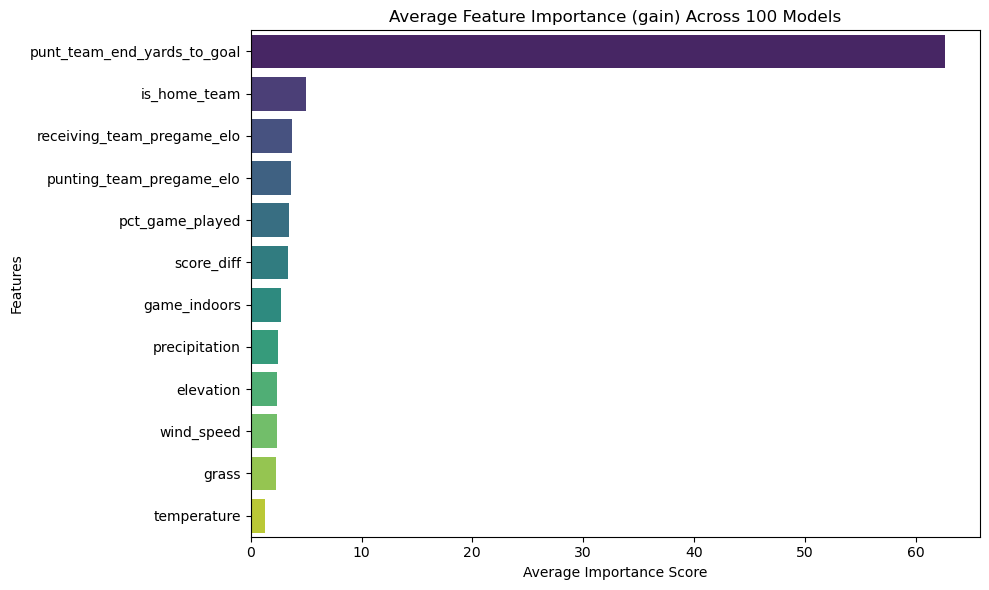

In [33]:
def plot_aggregated_feature_importance(models, importance_type="gain"):
    total_importance = {}

    # Aggregate importances across all models
    for model in tqdm(models, desc='Calculating Feature Importance'):
        importance = model.get_score(importance_type=importance_type)
        for feat, score in importance.items():
            total_importance[feat] = total_importance.get(feat, 0) + score

    # Average the importance by number of models
    for feat in total_importance:
        total_importance[feat] /= len(models)

    importance_df = pd.DataFrame({
        "Feature": list(total_importance.keys()),
        "Importance": list(total_importance.values())
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="Importance", 
        y="Feature", 
        data=importance_df, 
        palette="viridis", 
        hue="Feature", 
        dodge=False
    )
    plt.title(f"Average Feature Importance ({importance_type}) Across {len(models)} Models")
    plt.xlabel("Average Importance Score")
    plt.ylabel("Features")
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.show()

plot_aggregated_feature_importance(models, importance_type="gain") # gain, weight, cover

Average Test MAE over 100 models: 8.23680


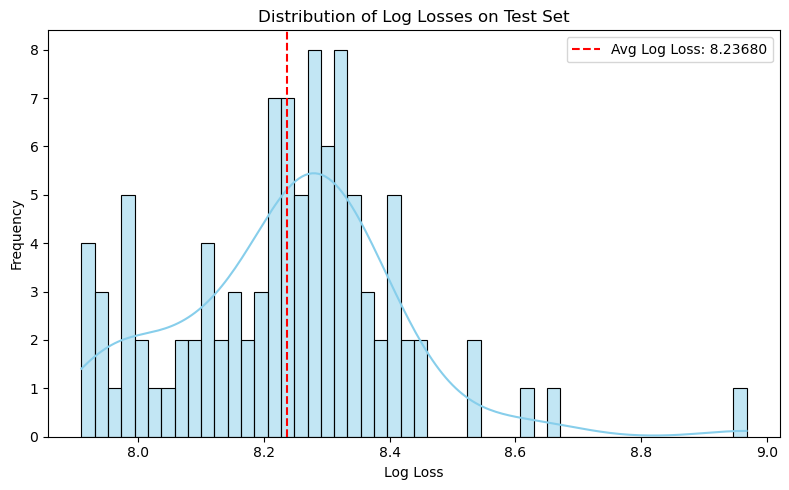

In [34]:
test_x = data_test.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
test_y = data_test['receiving_team_start_yards_to_goal'].values.ravel()
dtest = xgb.DMatrix(test_x)

maes = []

for model in models:
    preds = model.predict(dtest)
    mae = mean_absolute_error(test_y, preds)
    maes.append(mae)

avg_mae = np.mean(maes)
print(f"Average Test MAE over {len(models)} models: {avg_mae:.5f}")

plt.figure(figsize=(8, 5))
sns.histplot(maes, bins=50, kde=True, color="skyblue")
plt.axvline(avg_mae, color="red", linestyle="--", label=f"Avg Log Loss: {avg_mae:.5f}")
plt.title("Distribution of Log Losses on Test Set")
plt.xlabel("Log Loss")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
data_all = data.drop(columns=['game_id', 'receiving_team_start_yards_to_goal'])
dall = xgb.DMatrix(data_all)

preds_all_models = []

for model in models:
    preds = model.predict(dall)
    preds_all_models.append(preds)

preds_all_models = np.array(preds_all_models)

# Calculate the 5%, 50%, 95% percentiles and the mean for each sample
df_punts['pred_yards_to_goal_5'] = np.percentile(preds_all_models, 5, axis=0)
df_punts['pred_yards_to_goal_50'] = np.percentile(preds_all_models, 50, axis=0)
df_punts['pred_yards_to_goal_95'] = np.percentile(preds_all_models, 95, axis=0)
df_punts['pred_yards_to_goal_mean'] = np.mean(preds_all_models, axis=0)

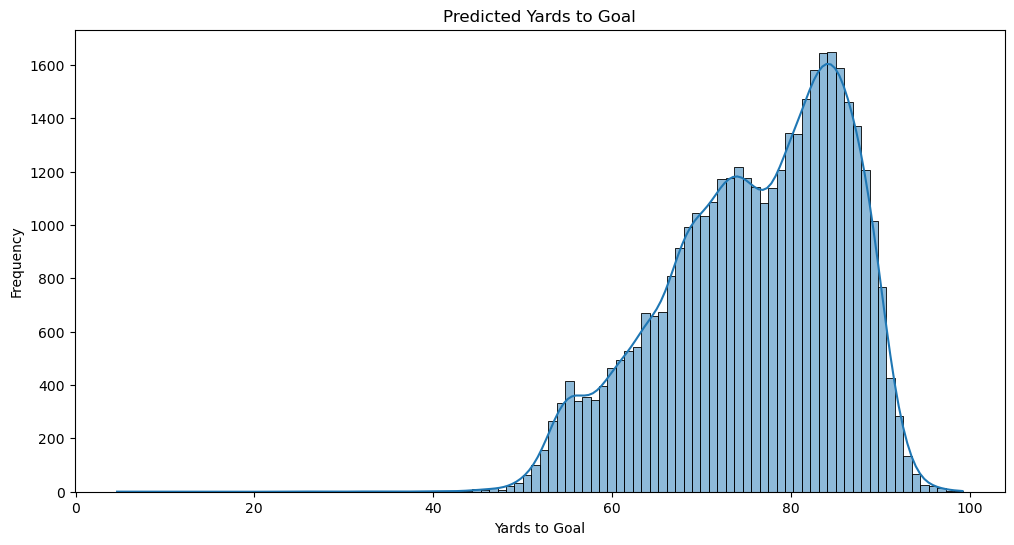

In [36]:
plt.figure(figsize=(12,6))
sns.histplot(df_punts.pred_yards_to_goal_50, bins=100, kde=True)
plt.title("Predicted Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_38220/3295317285.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))


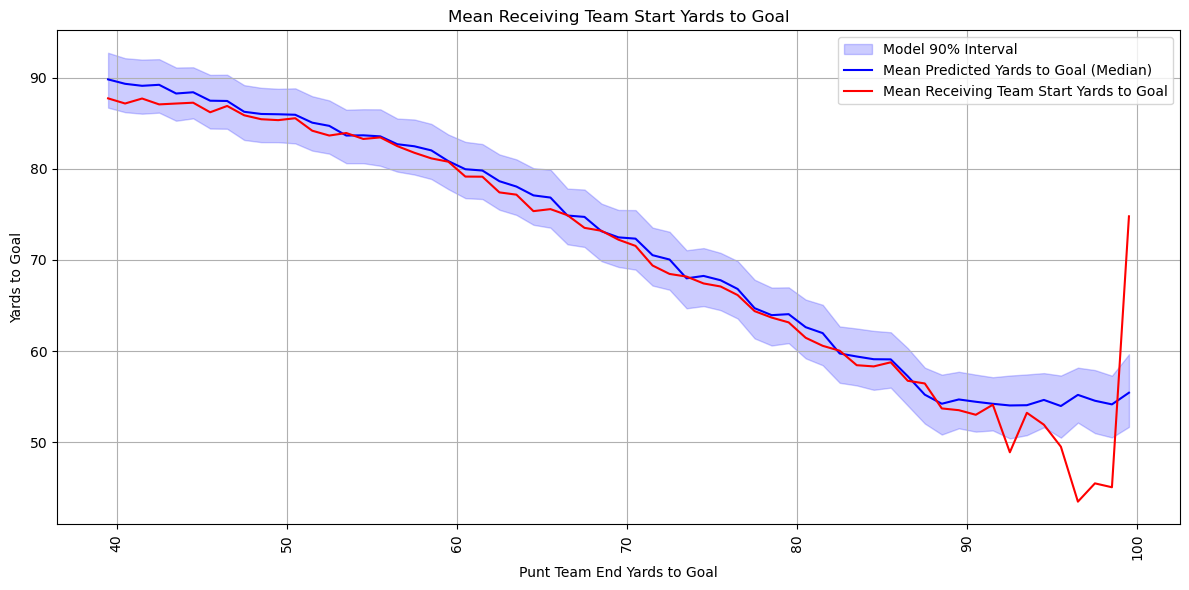

In [66]:
# Create the DataFrame with binned data
df_punt_start_yards_to_goal = (
    df_punts
    .groupby(pd.cut(df_punts.punt_team_end_yards_to_goal, np.linspace(0, 100, 101)))
    .agg(
        pred_yards_to_goal_50=('pred_yards_to_goal_50', 'mean'),
        pred_yards_to_goal_5=('pred_yards_to_goal_5', 'mean'),
        pred_yards_to_goal_95=('pred_yards_to_goal_95', 'mean'),
        receiving_team_start_yards_to_goal_mean=('receiving_team_start_yards_to_goal', 'mean')
    )
    .reset_index()
)

# Convert the categorical bins to numeric midpoints
df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'] = df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'].apply(
    lambda x: x.mid if pd.notnull(x) else np.nan
)

# Plot with uncertainty shading
plt.figure(figsize=(12, 6))

# Shaded area between 5th and 95th percentiles
plt.fill_between(
    df_punt_start_yards_to_goal['punt_team_end_yards_to_goal'],
    df_punt_start_yards_to_goal['pred_yards_to_goal_5'],
    df_punt_start_yards_to_goal['pred_yards_to_goal_95'],
    color='blue',
    alpha=0.2,
    label='Model 90% Interval'
)

# Prediction line (median)
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='pred_yards_to_goal_50', 
    data=df_punt_start_yards_to_goal,
    color='blue',
    label='Mean Predicted Yards to Goal (Median)'
)

# Actual mean
sns.lineplot(
    x='punt_team_end_yards_to_goal', 
    y='receiving_team_start_yards_to_goal_mean', 
    data=df_punt_start_yards_to_goal,
    color='red',
    label='Mean Receiving Team Start Yards to Goal'
)

plt.title("Mean Receiving Team Start Yards to Goal")
plt.xlabel("Punt Team End Yards to Goal")
plt.ylabel("Yards to Goal")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [61]:
data.drop_duplicates(['game_id']).head(10)

,game_id,punt_team_end_yards_to_goal,is_home_team,grass,elevation,wind_speed,precipitation,temperature,game_indoors,pct_game_played,score_diff,punting_team_pregame_elo,receiving_team_pregame_elo,receiving_team_start_yards_to_goal
0,332412309,78.0,-1,False,321.364166,3.4,0.0,82.0,False,0.169444,-7.0,1553.191164,1954.443118,58.0
5,332412579,52.0,-1,True,60.545486,0.0,0.0,93.9,False,0.828889,-17.0,2475.527442,3035.188373,94.0
7,332410154,85.0,-1,False,283.548584,13.9,0.0,84.0,False,0.501389,-10.0,804.297475,1961.923659,45.0
13,332410084,69.0,-1,False,231.650085,5.8,0.0,88.0,False,0.331944,-35.0,1483.120548,1737.071673,59.0
15,332412050,82.0,-1,False,285.481781,5.8,0.0,82.9,False,0.229444,5.0,1727.035813,1899.886323,64.0
20,332412116,76.0,-1,True,20.941137,8.1,0.0,86.0,False,0.251944,-14.0,807.707845,2171.347997,74.0
25,332410189,72.0,-1,False,205.905746,5.8,0.0,82.9,False,0.018611,0.0,2252.931586,1766.261879,62.0
30,332410135,66.0,-1,False,254.390228,10.3,0.0,90.0,False,0.289444,-4.0,1170.215523,2013.037060,97.0
33,332410041,79.0,1,True,6.515615,8.1,0.0,70.0,False,0.233611,0.0,2028.878257,1875.908868,63.0
37,332412393,84.0,-1,False,191.727982,10.3,0.0,92.8,False,0.231944,-14.0,713.944338,1521.995338,0.0


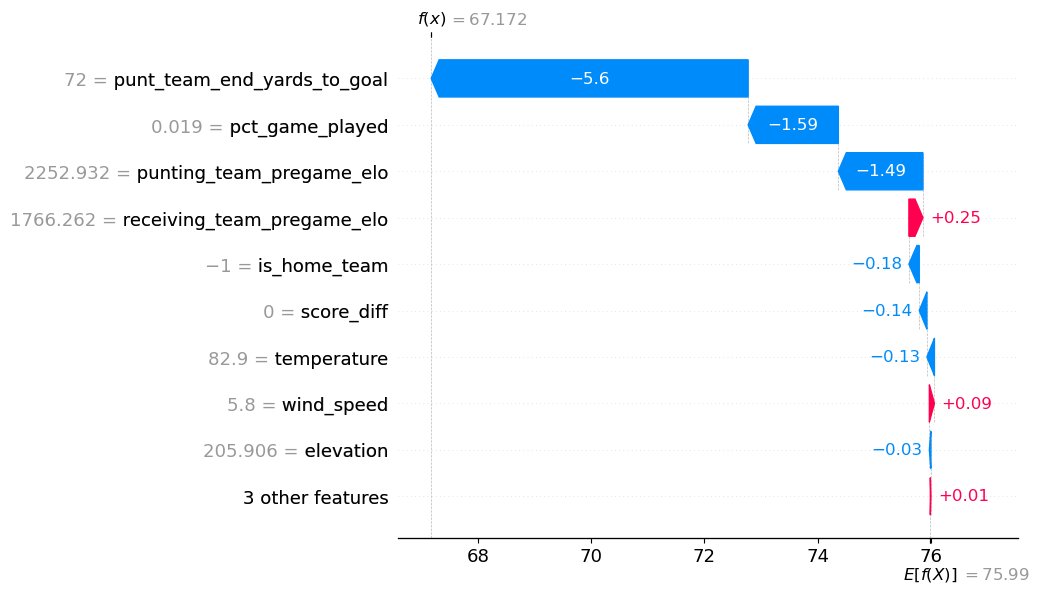

In [65]:
gid = 332410189

model = models[0]

game_data = data[data.game_id == gid].drop(columns=['game_id','receiving_team_start_yards_to_goal']).head(1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

### Make assumptions for punts inside the 40, that median yards to goal is 88 yards

In [38]:
df_punts_inside_40['pred_yards_to_goal_5'] = 80
df_punts_inside_40['pred_yards_to_goal_50'] = 88
df_punts_inside_40['pred_yards_to_goal_95'] = 96
df_punts_inside_40['pred_yards_to_goal_mean'] = 88

df_punts_final = pd.concat([df_punts, df_punts_inside_40], ignore_index=True)

In [39]:
model_dir = join(DATA_DIR, 'models', 'punt_yards_to_goal')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i, model in enumerate(models):
    model_path = os.path.join(model_dir, f"model_{i}.json")
    model.save_model(model_path)

print(f"Saved {len(models)} models to the '{model_dir}' folder.")

Saved 100 models to the '../data/models/punt_yards_to_goal' folder.
